## Análise Exploratória dos Dados
Para termos uma melhor compreensão dos datasets e ter perguntas exploratórias dos mesmos faremos uma análise inicial.

In [15]:
# Importação das libs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Sugestão de Colunas**
1. De `ocorrencia.csv`:
    * codigo_ocorrencia: (apenas para identificação, não usar no treino).
    * ocorrencia_classificacao: (Sua Variável Alvo/Target).
    * ocorrencia_uf: O local geográfico pode influenciar (clima, relevo).
    * ocorrencia_dia: Para extrair o Mês (sazonalidade) ou Ano.
    * ocorrencia_saida_pista: Binária (Sim/Não), fortíssima correlação com gravidade.

2. De `aeronave.csv`:
    * aeronave_tipo_veiculo: (Avião, Helicóptero, etc.) Fundamental.
    * aeronave_motor_tipo: (Jato, Pistão, Turboélice). Motores diferentes têm perfis de falha diferentes.
    * aeronave_fase_operacao: (Decolagem, Pouso, Cruzeiro). É onde a maioria dos acidentes se diferencia.
    * aeronave_ano_fabricacao: A idade da aeronave pode ser um fator relevante.

3. De `ocorrencia_tipo.csv`:
    * ocorrencia_tipo: (Ex: "Falha do Motor", "Perda de Controle").
> Uma ocorrência pode ter mais de um tipo, o que duplicaria linhas. Lembrar de fazer então algum um tratamento.

4. De `fator_contribuinte.csv`:
    * fator_area: (Fator Humano, Material, Operacional)

In [16]:
# Carregamento dos datasets
df_ocorrencia = pd.read_csv('arquivos/ocorrencia.csv', encoding='latin-1', sep=';')
df_aeronave = pd.read_csv('arquivos/aeronave.csv', encoding='latin-1',sep=';')
df_tipo = pd.read_csv('arquivos/ocorrencia_tipo.csv', encoding='latin-1',sep=';')
df_fator = pd.read_csv('arquivos/fator_contribuinte.csv', encoding='latin-1',sep=';')

# Fusão dos datasets
# Merge Ocorrencia + Aeronave (Chave comum é codigo_ocorrencia2)
df_merged = pd.merge(df_ocorrencia, df_aeronave, on='codigo_ocorrencia2', how='left')

# Merge + Tipo (Chave comum é codigo_ocorrencia1)
# lembrar de que: left_on no dataset acumulado, right_on no dataset novo
df_merged = pd.merge(df_merged, df_tipo, left_on='codigo_ocorrencia1', right_on='codigo_ocorrencia1', how='left')

# Merge + Fator (Chave comum é codigo_ocorrencia3)
df_merged = pd.merge(df_merged, df_fator, left_on='codigo_ocorrencia3', right_on='codigo_ocorrencia3', how='left')

# Selecão das Colunas de Interesse
colunas_interesse = [
    # Identificador e Alvo
    'codigo_ocorrencia', 'ocorrencia_classificacao',
    
    # Contexto (Ocorrencia)
    'ocorrencia_uf', 'ocorrencia_dia', 'ocorrencia_saida_pista',
    
    # Aeronave
    'aeronave_tipo_veiculo', 'aeronave_motor_tipo', 
    'aeronave_fase_operacao', 'aeronave_ano_fabricacao',
    
    # Tipo do problema
    'ocorrencia_tipo',
    
    # Fatores (Causas)
    'fator_area' # Ou 'fator_nome' se quiser mais detalhe
]

# Criação do dataset final limpo
df_final = df_merged[colunas_interesse].copy()

# Remover duplicatas exatas se houver
df_final.drop_duplicates(inplace=True)

# Visualização rápida do dataset final
print(df_final.info())
print(df_final.head())

<class 'pandas.core.frame.DataFrame'>
Index: 15375 entries, 0 to 21482
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   codigo_ocorrencia         15375 non-null  int64  
 1   ocorrencia_classificacao  15375 non-null  object 
 2   ocorrencia_uf             15375 non-null  object 
 3   ocorrencia_dia            15375 non-null  object 
 4   ocorrencia_saida_pista    15375 non-null  object 
 5   aeronave_tipo_veiculo     15374 non-null  object 
 6   aeronave_motor_tipo       14883 non-null  object 
 7   aeronave_fase_operacao    15374 non-null  object 
 8   aeronave_ano_fabricacao   14383 non-null  float64
 9   ocorrencia_tipo           15369 non-null  object 
 10  fator_area                3813 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 1.4+ MB
None
   codigo_ocorrencia ocorrencia_classificacao ocorrencia_uf ocorrencia_dia  \
0              87125                

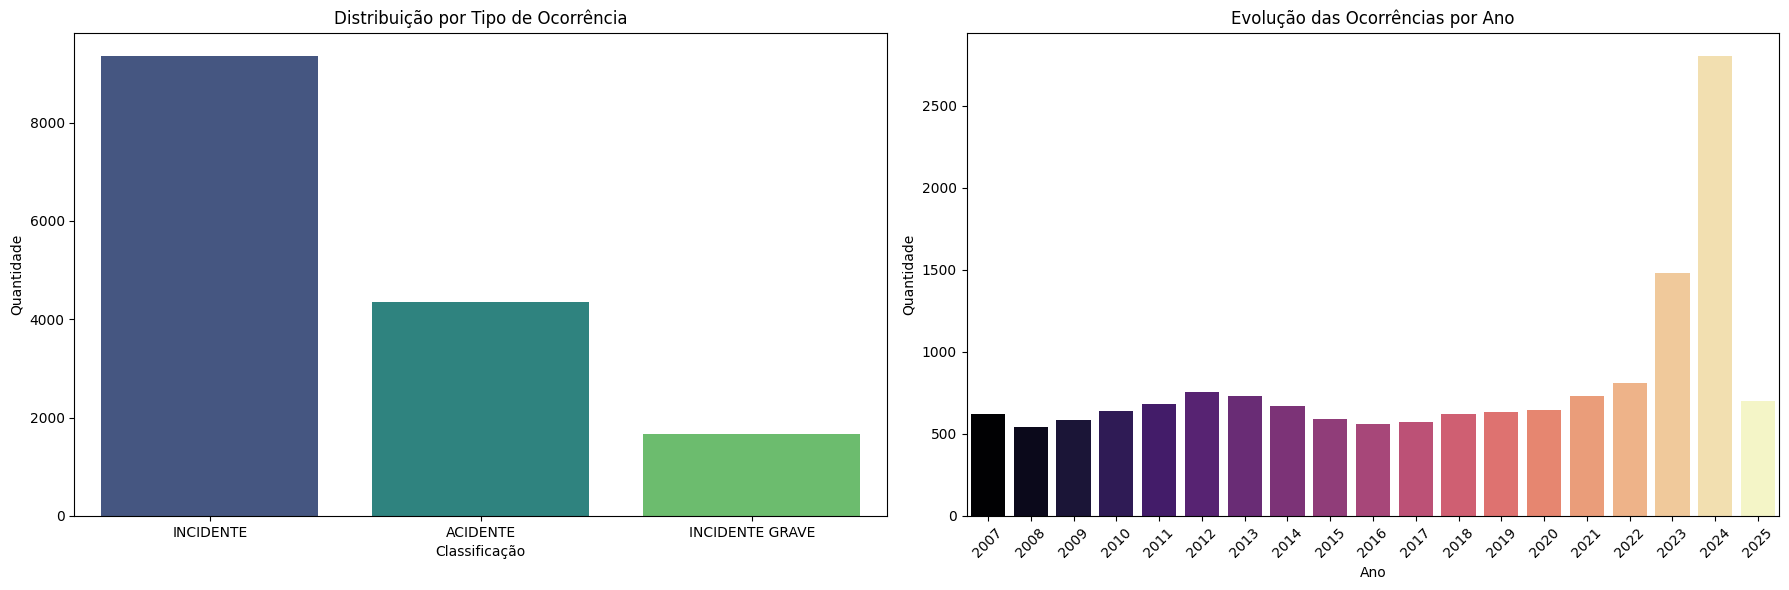

In [17]:
# Conversão da coluna de data para datetime
df_final['ocorrencia_dia'] = pd.to_datetime(df_final['ocorrencia_dia'], dayfirst=True, errors='coerce')
df_final['ano'] = df_final['ocorrencia_dia'].dt.year  # coluna de ano para análise temporal

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Gráfico de Tipos de Ocorrência
sns.countplot(data=df_final, x='ocorrencia_classificacao',hue='ocorrencia_classificacao', ax=axes[0], palette='viridis', legend=False)
axes[0].set_title('Distribuição por Tipo de Ocorrência')
axes[0].set_xlabel('Classificação')
axes[0].set_ylabel('Quantidade')

# Gráfico de Ocorrências por Ano
sns.countplot(data=df_final, x='ano', hue='ano', ax=axes[1], palette='magma', legend=False)
axes[1].set_title('Evolução das Ocorrências por Ano')
axes[1].set_xlabel('Ano')
axes[1].set_ylabel('Quantidade')
# Rotacionar os anos no eixo X para não ficarem muito juntinhos
axes[1].tick_params(axis='x', rotation=45)

# Ajustar o layout para não cortar textos
plt.tight_layout()

plt.show()

Top 10 Modelos em Acidentes:
aeronave_tipo_veiculo
AVIÃO          3332
HELICÓPTERO     546
ULTRALEVE       353
***              67
PLANADOR         34
ANFÍBIO          12
TRIKE             5
GIROCÓPTERO       4
DIRIGÍVEL         2
DRONE             1
Name: count, dtype: int64


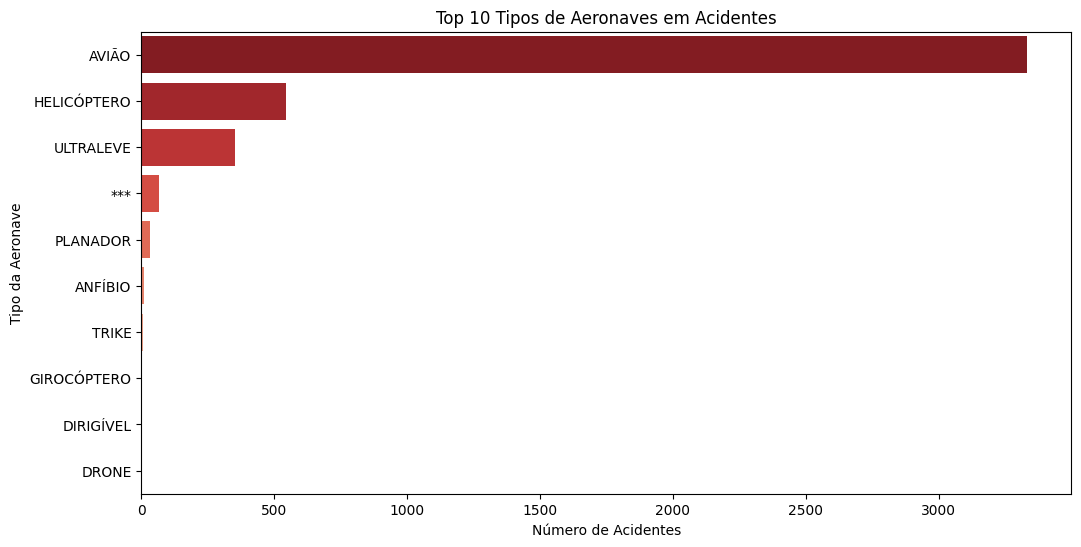

In [18]:
# Filtro para o que é acidente
df_acidentes = df_final[df_final['ocorrencia_classificacao'] == 'ACIDENTE']

# Contar os tipos de aeronaves mais envolvidos
top_aeronaves = df_acidentes['aeronave_tipo_veiculo'].value_counts().head(10)

print("Top 10 Modelos em Acidentes:")
print(top_aeronaves)

# Gráfico
plt.figure(figsize=(12, 6))
sns.barplot(x=top_aeronaves.values, y=top_aeronaves.index, hue=top_aeronaves.index, palette='Reds_r', legend=False)
plt.title('Top 10 Tipos de Aeronaves em Acidentes')
plt.xlabel('Número de Acidentes')
plt.ylabel('Tipo da Aeronave')
plt.show()

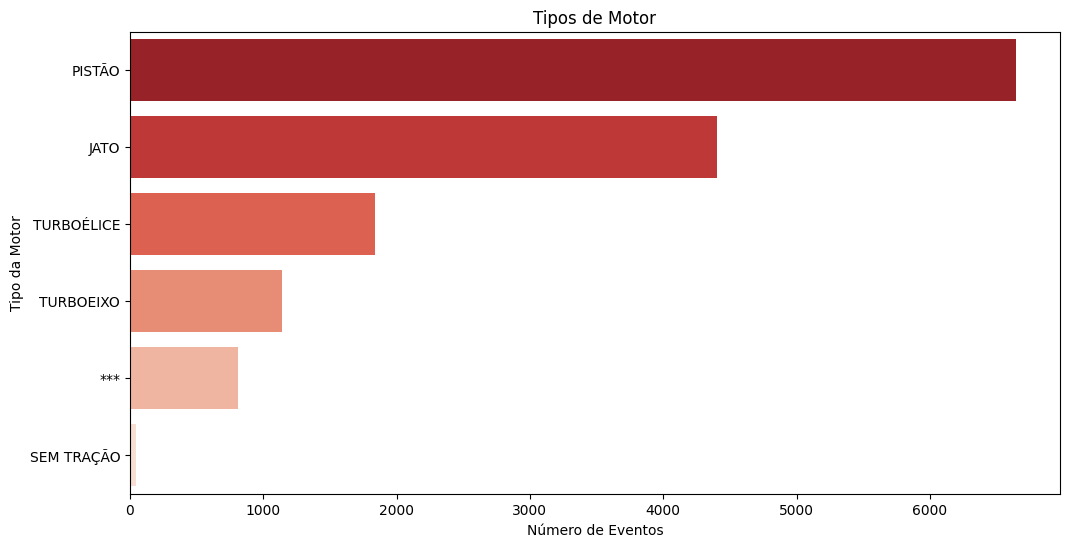

In [19]:
# Contar os tipso de motor mais envolvidos em eventos como um todo
top_motor = df_final['aeronave_motor_tipo'].value_counts().head(10)

# Gráfico
plt.figure(figsize=(12, 6))
sns.barplot(x=top_motor.values, y=top_motor.index, hue=top_motor.index, palette='Reds_r', legend=False)
plt.title('Tipos de Motor')
plt.xlabel('Número de Eventos')
plt.ylabel('Tipo da Motor')
plt.show()

## Perguntas Exploratórias